In [ ]:
# Install the ultralytics package using pip
!pip install ultralytics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 723.1/723.1 kB 7.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 30.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 50.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 46.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 705.4 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 3.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 8.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 9.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 7.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 2.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 166.0/166.0 MB 6.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.1/99.1 kB 11.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━

In [ ]:
from ultralytics import YOLO
from matplotlib import pyplot as plt
from PIL import Image

# Update This Cell With the Model's weight

In [ ]:
my_new_model = YOLO('/content/drive/MyDrive/Models/yolov8l.pt')

WARNING ⚠️ /content/drive/MyDrive/Models/yolov8l.pt appears to require 'dill', which is not in ultralytics requirements.
AutoInstall will run now for 'dill' but this feature will be removed in the future.
Recommend fixes are to train a new model using the latest 'ultralytics' package or to run a command with an official YOLOv8 model, i.e. 'yolo predict model=yolov8n.pt'
requirements: Ultralytics requirement ['dill'] not found, attempting AutoUpdate...
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 4.0 MB/s eta 0:00:00

requirements: AutoUpdate success ✅ 6.9s, installed 1 package: ['dill']
requirements: ⚠️ Restart runtime or rerun command for updates to take effect



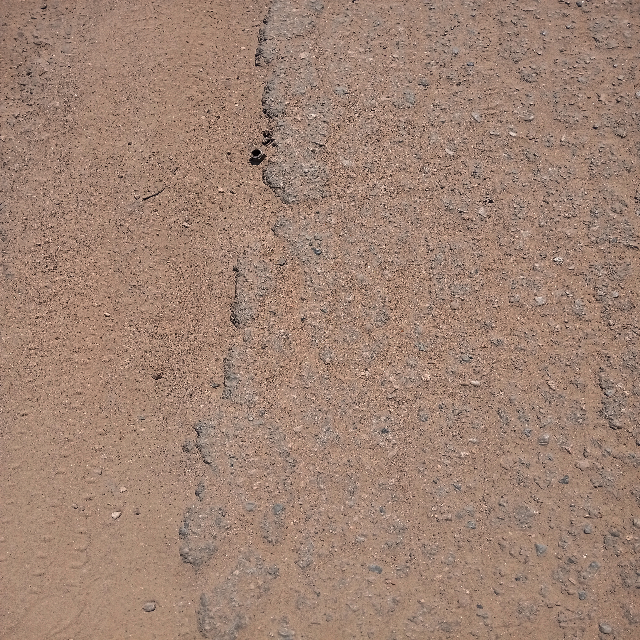

In [ ]:
import cv2
import numpy as np
from google.colab.patches import cv2_imshow

def preprocess_image(image_path):
    # Read the image
    img = cv2.imread(image_path)

    # Resize the image to 640x640
    img_resized = cv2.resize(img, (640, 640))

    # Convert the image to float32 for contrast stretching
    img_float32 = img_resized.astype(np.float32)

    # Apply contrast stretching
    min_intensity = np.min(img_float32)
    max_intensity = np.max(img_float32)
    img_contrast_stretched = ((img_float32 - min_intensity) / (max_intensity - min_intensity)) * 255

    # Convert back to uint8
    img_contrast_stretched = img_contrast_stretched.astype(np.uint8)

    # Apply gamma correction
    gamma = 2  # Adjust gamma value as needed
    gamma_corrected = np.uint8(cv2.pow(img_contrast_stretched / 255.0, gamma) * 255)

    return gamma_corrected


# Update the img path

In [ ]:
# Update the image path
input_image_path = "/content/drive/MyDrive/Models/images/IMG20240308123618.jpg"
new_image = preprocess_image(input_image_path)

# Display the preprocessed image
cv2_imshow(new_image)

In [ ]:
new_results = my_new_model.predict(new_image, conf=0.2)  #Adjust conf threshold



0: 640x640 1 Crack, 3929.5ms
Speed: 15.8ms preprocess, 3929.5ms inference, 5.3ms postprocess per image at shape (1, 3, 640, 640)


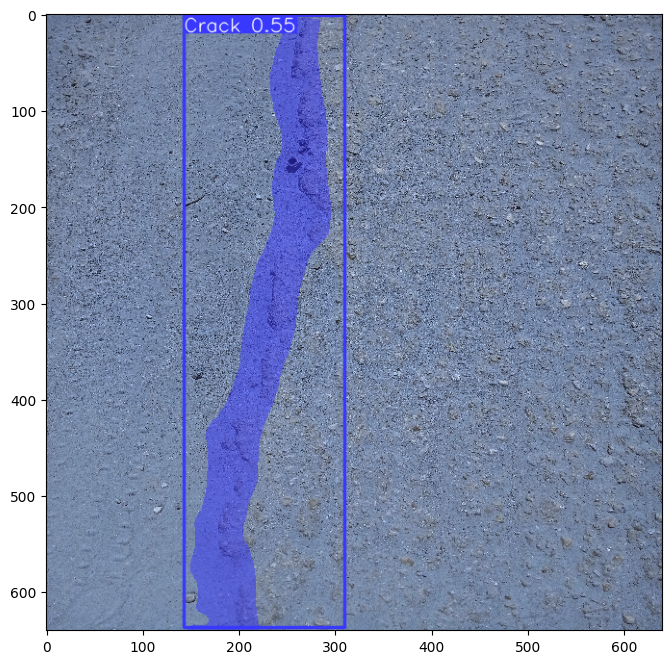

In [ ]:
new_result_array = new_results[0].plot()
plt.figure(figsize=(8, 8))
plt.imshow(new_result_array)

In [ ]:
new_result = new_results[0]
extracted_masks = new_result.masks.data

masks_array = extracted_masks.cpu().numpy()

In [ ]:
from scipy.ndimage import gaussian_filter

# Smooth each mask in the masks_array
smoothed_masks = []
for mask in masks_array:
    smoothed_mask = gaussian_filter(mask, sigma=4)  # Adjust sigma for different levels of smoothing
    smoothed_masks.append(smoothed_mask)

masks_array = np.array(smoothed_masks)


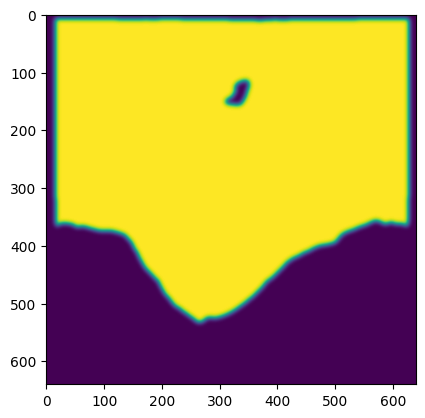

In [ ]:
plt.imshow(masks_array[0])

In [ ]:
class_names = new_result.names.values()
# Extract the boxes, which likely contain class IDs
detected_boxes = new_result.boxes.data
# Extract class IDs from the detected boxes
class_labels = detected_boxes[:, -1].int().tolist()
# Initialize a dictionary to hold masks by class
masks_by_class = {name: [] for name in new_result.names.values()}

# Iterate through the masks and class labels
for mask, class_id in zip(extracted_masks, class_labels):
    class_name = new_result.names[class_id]  # Map class ID to class name
    masks_by_class[class_name].append(mask.cpu().numpy())


for class_name, masks in masks_by_class.items():
    print(f"Class Name: {class_name}, Number of Masks: {len(masks)}")


Class Name: Crack, Number of Masks: 0
Class Name: Edgecrack, Number of Masks: 0
Class Name: pothole, Number of Masks: 1


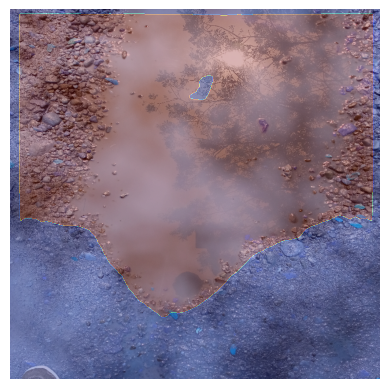

In [ ]:
#pothole_mask = masks_by_class['pothole']

# Extract the original image
#orig_img = new_result.orig_img
#orig_img.shape

# Display the original image
#plt.imshow(orig_img)

# Overlay the mask with some transparency
#plt.imshow(alpha_granule_masks[1], cmap='jet', alpha=0.3)
#plt.imshow(pothole_mask[0], cmap='jet', alpha=0.3)
#plt.axis('off') # Turn off axis labels
#plt.show()

In [ ]:
import pandas as pd
from skimage.measure import regionprops

# Initialize a list to store the properties
props_list = []

# Iterate through all classes
for class_name, masks in masks_by_class.items():
    # Iterate through the masks for this class
    for mask in masks:
        # Convert the mask to an integer type if it's not already
        mask = mask.astype(int)

        # Apply regionprops to the mask
        props = regionprops(mask)

        # Extract the properties you want (e.g., area, perimeter) and add them to the list
        for prop in props:
            area = prop.area
            perimeter = prop.perimeter
            # Add other properties as needed

            # Append the properties and class name to the list
            props_list.append({'Class Name': class_name, 'Area': area, 'Perimeter': perimeter})

# Convert the list of dictionaries to a DataFrame
props_df = pd.DataFrame(props_list)

# Now props_df contains the properties and class names for all regions

# Save the DataFrame to a CSV file
props_df.to_csv(index=False)

props_df

,Class Name,Area,Perimeter
0,pothole,254611,2262.16461
